# EX 3 using TF

## Set up

In [1]:
# install packages
# !pip install jiwer
# !pip install pandas
# !pip install matplotlib
# !pip install sentence-


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import time
from tqdm import tqdm
import pickle
import random
import torch

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


%matplotlib inline

cuda


## Data Prep
### Load Data

In [3]:
data_path = "/home/slimlab/Downloads/LJSpeech-1.1"
wavs_path = data_path + "/16khz/wavs/"
metadata_path = data_path + "/metadata.csv"

# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ036-0011,(three) evidence establishing the ownership of...
1,LJ016-0099,These men managed to cut a hole in the ceiling...
2,LJ016-0425,"When visited one day in the condemned cell, ju..."


### Split Data

In [4]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


### Character ↔️ Number Function

In [5]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [6]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data encoding function
takes in a pice of audio and a trancript and outputs a spectrogram of the audio with the encoded transcript

In [7]:
from tensorflow.python.ops.gen_spectral_ops import fft
# int. scalar tensor. window length in samples
frame_length = 256
# int. scalar tensor. number of samples to step
frame_step = 160
# int scalar tensor. size of FFT
fft_length = 384

def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")

    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float, this step might not be necessary
    audio = tf.cast(audio, tf.float32)

    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, 
        frame_length=frame_length, 
        frame_step=frame_step, 
        fft_length=fft_length
    )

    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)

    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")

    # 9. Map the characters in label to numbers
    label = char_to_num(label)

    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [8]:
# encode_single_sample(metadata_df.file_name[0], metadata_df.normalized_transcription[0])


### Create dataset objects

In [19]:
batch_size = 64

# define training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)

train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Checkout one sample

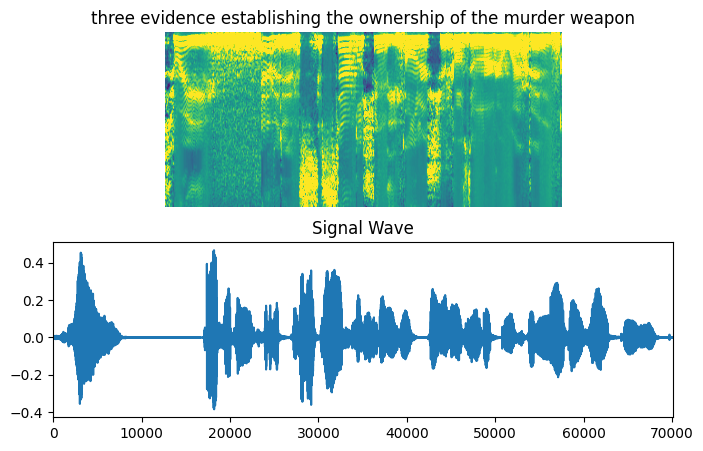

In [20]:
fig = plt.figure(figsize=(8,5))

for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))

plt.show()

## Functions

In [21]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


In [22]:
# embeds and calculates cosine similarity
# returns matrix of all cosine similaritys
# between s and s1
def get_cos_sim(s, s1, model=minilm):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)


# get the diagonals of the cosine matrix
def get_respective_cos_sim(s, s1, model=minilm):
    cos_sim = get_cos_sim(s, s1, model)
    return cos_sim.diagonal()

# smoothing relu so that there will never be
# log of negative number or 0
def relu(x):
    return torch.max(torch.tensor(0.0000001),x)

# custom cosine loss
# the negative log of the cosine similarity
def get_cos_loss(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((len(s),1))
    return -np.log(cos_sim.cpu()).numpy()

def get_cos_distance(s, s1, model=minilm):
    cos_sim = get_respective_cos_sim(s, s1, model)
    # remove negatives and look at neg loglikilood
    cos_sim = relu(cos_sim).reshape((len(s),1))
    return 1 - cos_sim.cpu().numpy()


# decodes set of label
def get_labels(y):
    gt = []
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    return gt

In [23]:
# Normal CTCLoss function
@torch.no_grad()
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [24]:
@torch.no_grad()
def CTC_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    torch.cuda.empty_cache() 
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + cos_loss

In [25]:
@torch.no_grad()
def Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    # loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return cos_loss

In [26]:
@torch.no_grad()
def CTC_Cosine2_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_loss = get_cos_loss(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss + tf.math.square(cos_loss)

In [27]:
@torch.no_grad()
def CTC_by_Cosine_Loss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    y_true_labs = get_labels(y_true)
    # print(y_true_labs)
    y_pred_labs = decode_batch_predictions(y_pred)
    # print(y_pred_labs)
    cos_distance = get_cos_distance(y_true_labs, y_pred_labs)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    # print(cos_loss)
    return loss * cos_distance


## Model

In [28]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128, loss=CTCLoss):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="output")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.legacy.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=loss, run_eagerly=True)
#     model.compile(optimizer=opt, loss=loss)
    
    return model




In [19]:
model_base = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=128,
    loss=CTCLoss,
)

In [29]:
model_cos = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=128,
    loss=CTC_by_Cosine_Loss,
    
)


In [30]:
model_cos.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

## Training

## Testing

In [31]:
gt = []
for X, y in train_dataset:
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        gt.append(label)
    break
gt[:2]

['three evidence establishing the ownership of the murder weapon',
 'these men managed to cut a hole in the ceiling of the ward near the iron cage on the landing and so got access to the roof']

In [32]:
batch_predictions = model_cos.predict(X)
batch_predictions_decoded = decode_batch_predictions(batch_predictions)
batch_predictions_decoded[:2]

2/2 [==============================] - 4s 186ms/step


['aeaemalmemg!megemgemlb', 'jemam!m!gemegemetmemea!met!mgmamegmalmea!mlcldlb']

In [34]:
# len(batch_predictions_decoded)

In [35]:
# get_cos_distance(get_labels(y), batch_predictions_decoded)

get_cos_distance(['i loathe you'], ['i love you'])

array([[0.60988617]], dtype=float32)

In [36]:
# CTC_by_Cosine_Loss(y, model_cos.predict(X))
# model_cos.loss

In [39]:
for i in range(1000):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model_cos(X)
        loss = model_cos.loss(y, y_pred)

    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(loss, model_cos.trainable_variables)
    model_cos.optimizer.apply_gradients(zip(grad, model_cos.trainable_weights))
    
    if i % 100 == 0:
        print(decode_batch_predictions(y_pred)[:4])
        print(i, ': ', loss.numpy().mean())
# if step % 200 == 0:
#     print('avg. loss at step: ', step, ' = ', loss.numpy().mean())

['', '', '', '']
0 :  603.58203
['', '', '', '']
100 :  284.28174
['t ', 't ', 't ', 't ']
200 :  285.1833
['t ', 'th ', 'th ', 't ']
300 :  280.7711


KeyboardInterrupt: 

In [44]:
get_performance(model_cos, validation_dataset)

getting performance


100%|██████████| 21/21 [00:58<00:00,  2.80s/it]

----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9803
Avg. Cos Distance: 0.9502
----------------------------------------------------------------------------------------------------
Target    : said that oswald told her that he had returned because quote i didn't find what i was looking for end quote
Prediction: t 
Word Error Rate For Example: 1.0000
Cos Dis: 0.9495
----------------------------------------------------------------------------------------------------
Target    : the prisoner made an elaborate defense in which he sought to vilify the character of deceased
Prediction: th 
Word Error Rate For Example: 1.0000
Cos Dis: 1.0026
----------------------------------------------------------------------------------------------------


(0.9803342299043167, 0.9501510957725176)

In [ ]:
get_performance(model_cos, train_dataset)

getting performance


 49%|████▉     | 91/185 [01:09<01:05,  1.45it/s]

In [46]:
# 3.12it/s
# 2 it/
# ----------------------------------------------------------------------------------------------------
# Word Error Rate: 0.9898
# Avg. Cos Distance: 0.9436
# ----------------------------------------------------------------------------------------------------
# Target    : and although it was not a violation of the law to carry a placard that they were not to tolerate any actions such as the stevenson incident
# Prediction: ta as e e e the ry thero l dn cs it c c csi thi the y e
# Word Error Rate For Example: 0.9259
# Cos Dis: 0.9086
# ----------------------------------------------------------------------------------------------------
# Target    : and the aggregate amount of debts sued for was eightyone thousand seven hundred ninetyone pounds
# Prediction: ae eh e thet thtsther eererer deretherethe  oao
# Word Error Rate For Example: 1.0000
# Cos Dis: 0.9223
# ----------------------------------------------------------------------------------------------------
# (0.989845275649692, 0.9435543767570741)

10.256410256410255

In [38]:
model_cos.optimizer.apply_gradients(zip(grad, model_cos.trainable_weights))


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [36]:
# for i in tqdm(range(1000)):
#     with tf.GradientTape() as tape:
#         # Forward pass
#         y_pred = model_cos(X)
        
#         # Get loss
#         loss = CTC_Cosine_Loss(y, y_pred)
#     if i % 100 == 20:
#         print(loss.numpy().mean())
#     # Calculate gradients with respect to every trainable variable
#     grad = tape.gradient(loss, model_cos.trainable_variables)
#     model_cos.optimizer.apply_gradients(
#         zip(grad, model_cos.trainable_weights)
#     )
    

In [39]:
loss.numpy().mean()


47.51098

In [47]:
# y_pred = model_cos(X)
# batch_predictions_decoded = decode_batch_predictions(y_pred)
# batch_predictions_decoded

In [46]:
# get_labels(y)

In [45]:
wer(get_labels(y)[0],batch_predictions_decoded[0])

0.6666666666666666

In [ ]:
for i in tqdm(range(1)):
    with tf.GradientTape() as tape:
        # Forward pass
        y_pred = model_base(X)
        
        # Get loss
        loss = CTC_Loss(y, y_pred)
        
    if i % 100 == 20:
        print(loss.numpy().mean())    
    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(loss, model_base.trainable_variables)
    model_base.optimizer.apply_gradients(
        zip(grad, model_cos.trainable_weights)
    )

In [ ]:
loss

In [ ]:
# model_cos.test_step(X)['loss']

In [ ]:
# epochs = 20
# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))
#     for step, (X,y) in enumerate(train_dataset):
#         with tf.GradientTape() as tape:
#             # Forward pass
#             y_pred = model_cos(X)
#             loss = CTC_Cosine_Loss(y, y_pred)

#             # Calculate gradients with respect to every trainable variable
#             grad = tape.gradient(loss, model_cos.trainable_variables)

#             model_cos.optimizer.apply_gradients(
#                 zip(grad, model_cos.trainable_weights)
#             )

#             if step == 0:
#                 batch_predictions = model_cos.predict(X)
#                 batch_predictions = decode_batch_predictions(batch_predictions)
#                 targets = get_labels(y)
#                 wer_score = wer(targets, batch_predictions)
#                 avg_cos_dis = get_cos_loss(targets, batch_predictions).mean()
#                 print("-" * 100)
#                 print(f"Word Error Rate: {wer_score:.4f}")
#                 print(f"Loss: {loss.numpy().mean():.4f}")
#                 print(f"Avg. Cos Loss: {avg_cos_dis:.4f}")
#                 print("-" * 100)
#                 for i in np.random.randint(0, len(batch_predictions), 2):
#                     print(f"Target    : {targets[i]}")
#                     print(f"Prediction: {batch_predictions[i]}")
#                     print(f"Word Error Rate For Example: {wer(targets[i], batch_predictions[i]):.4f}")
#                     print(f"Avg. Cos Loss: {get_cos_sim(targets[i], batch_predictions[i]).item():.4f}")
#                     print("-" * 100)
#         break

In [ ]:
# get_cos_sim('at this stage it breathes equally by lungs and by gills  ie both air and water','')

In [ ]:
# model_cos.save('cosine_penaltiy_20epochs')


In [68]:
# model_cos.save_weights('cos_weights_20epochs')
# model_base.loss
train(model_cos, 1)

  0%|          | 0/1 [00:00<?, ?it/s]


Start of epoch 0



  0%|          | 1/369 [00:00<05:48,  1.06it/s]

avg. loss at step:  0  =  148.25203



  0%|          | 0/1 [02:23<?, ?it/s]


KeyboardInterrupt: 

In [42]:
def train(model, epochs, name='model'):
    hist = {
        'losses': [],
        
        'train_wer': [],
        # 'train_cos_loss': [],
        'train_cos_dis': [],
        
        'val_wer': [],        
        # 'val_cos_loss': [],
        'val_cos_dis': []
    }
    
    for epoch in tqdm(range(epochs)):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()
        
        for step, (X,y) in enumerate(tqdm(train_dataset)):
            with tf.GradientTape() as tape:
                # Forward pass
                y_pred = model(X)
                loss = model.loss(y, y_pred)

                hist['losses'].extend(loss.numpy().reshape(1, len(loss)).tolist()[0])

            # Calculate gradients with respect to every trainable variable
            grad = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grad, model.trainable_weights))
            
            if step % 200 == 0:
                print('avg. loss at step: ', step, ' = ', loss.numpy().mean())
        
        
        train_wer, train_cos_dis = get_performance(model, train_dataset)
        val_wer, val_cos_dis = get_performance(model, validation_dataset)
        
        hist['train_wer'].append(train_wer)
        # hist['train_cos_loss'].append(train_cos_loss)
        hist['train_cos_dis'].append(train_cos_dis)
        
        hist['val_wer'].append(val_wer)
        # hist['val_cos_loss'].append(val_cos_loss)
        hist['val_cos_dis'].append(val_cos_dis)
        
#         if epoch % 5 == 0:
#             model.save_weights(name + '_weights_' + str(epoch))
        print('Time: ', time.time() - start_time)
    return hist

In [43]:
def get_performance(model, data):
    with torch.no_grad():
        print('getting performance')
        predictions = []
        targets = []
        cos_losses = []
        cos_distances = []

        # for step, (X,y) in enumerate(tqdm(data)):
        for batch in tqdm(data):
            X, y = batch

            # make prediction
            batch_predictions = model(X, training = False)

            # convert prediction and target into text
            batch_predictions = decode_batch_predictions(batch_predictions)
            temp_target = get_labels(y)

            # add text to lists
            predictions.extend(batch_predictions)
            targets.extend(temp_target)
        
            # get cosine loss
            # cos_losses.extend(get_cos_loss(temp_target, batch_predictions).reshape(1, len(temp_target)).tolist()[0])
            # torch.cuda.empty_cache()
            # get average cosine distance (1 - cos(x,y))
            cos_distances.extend((1 - get_respective_cos_sim(temp_target, batch_predictions)).tolist())        
            # torch.cuda.empty_cache()

        # get metrics
        wer_score = wer(targets, predictions)
        # avg_cos_loss = np.mean(cos_losses)
        avg_cos_distance = np.mean(cos_distances)

        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        # print(f"Avg. Cos Loss: {avg_cos_loss:.4f}")
        print(f"Avg. Cos Distance: {avg_cos_distance:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print(f"Word Error Rate For Example: {wer(targets[i], predictions[i]):.4f}")
            print(f"Cos Dis: {1 - get_cos_sim(targets[i], predictions[i]).item():.4f}")
            print("-" * 100)
    return wer_score, avg_cos_distance

In [ ]:
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

In [ ]:
# history_cos = train(model_cos, epochs=50, name='model_cos')

In [ ]:
# history_base = train(model_base, epochs=1, name='model_base')

In [ ]:
# with open('history_cos.pkl', 'wb') as handle:
#     pickle.dump(history_cos, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('history_base.pkl', 'wb') as handle:
#     pickle.dump(history_cos, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('history_cos.pkl', 'rb') as handle:
    history_cos = pickle.load(handle)

In [ ]:
with open('history_base.pkl', 'rb') as handle:
    history_base = pickle.load(handle)

## ReRun get performance

In [ ]:
base_dir = "/home/slimlab/ryan/severity-measures-asr/base_model_weights/"
ctc_cos_dir = "/home/slimlab/ryan/severity-measures-asr/cos_ctc_model_weights/"

def rerun_performance(model, epochs, name='model', weights_dir=base_dir):
    rerun_hist = {
        
        'train_wer': [],
        'train_cos_loss': [],
        'train_cos_dis': [],
        
        'val_wer': [],        
        'val_cos_loss': [],
        'val_cos_dis': []
    }
    
    for epoch in tqdm(range(epochs)):
#         print("\nStart of epoch %d" % (epoch,) + ' with ' + weights_dir + name + '_weights_' + str(epoch))    
        model.load_weights(weights_dir + name + '_weights_' + str(epoch))
        train_wer, train_cos_loss, train_cos_dis = get_performance(model, train_dataset)
        val_wer, val_cos_loss, val_cos_dis = get_performance(model, validation_dataset)

        rerun_hist['train_wer'].append(train_wer)
        rerun_hist['train_cos_loss'].append(train_cos_loss)
        rerun_hist['train_cos_dis'].append(train_cos_dis)

        rerun_hist['val_wer'].append(val_wer)
        rerun_hist['val_cos_loss'].append(val_cos_loss)
        rerun_hist['val_cos_dis'].append(val_cos_dis)
    
    return rerun_hist

In [ ]:
base_rerun_hist = rerun_performance(model_base, 50, 'model_base', base_dir)

In [ ]:
cos_ctc_rerun_hist = rerun_performance(model_cos, 50, 'model_cos', ctc_cos_dir)

In [ ]:
with open('base_rerun_hist.pkl', 'wb') as handle:
    pickle.dump(base_rerun_hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('cos_ctc_rerun_hist.pkl', 'wb') as handle:
    pickle.dump(cos_ctc_rerun_hist, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
base_rerun_hist